In [120]:

%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
pd.options.display.mpl_style = 'default'

import inspect, os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 
from src.dashboard_helpers import Test, custom_amount_stats
from src.data_retrieval import *
from db_utils import query_hive_ssh
import copy


def doctor_payment_data(t, n_clicks, conversion_rate, average_donation, banner_name, method_name ):
    t = copy.deepcopy(t)
    donations = int(n_clicks * conversion_rate)
    clicks = t.data[banner_name]['clicks']
    clicks = clicks.reset_index()
    del clicks['timestamp']
    gw = pd.DataFrame([[0, method_name]]*n_clicks )
    gw.columns = ['impressions_seen', 'payment_method']
    t.data[banner_name]['clicks'] = pd.concat([clicks, gw], axis=0)

    dons = t.data[banner_name]['donations']
    dons = dons.reset_index()
    del dons['timestamp']
    gw = pd.DataFrame([[average_donation, 0, method_name]]*donations )
    gw.columns = ['amount', 'impressions_seen', 'payment_method']
    t.data[banner_name]['donations'] = pd.concat([dons, gw], axis=0)
    return t

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
hive_query = """
SELECT 
  a.banner,
  a.recurring,
  COUNT(*) as n 
FROM (
    SELECT
      PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'bannername') as banner,
      PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'recurring') as recurring
    FROM wmf.webrequest 
    WHERE year = 2015
      AND (month = 4 AND day = 10 AND hour in (12, 13, 14))
      OR  (month=4   AND day = 28 AND hour in (12, 13, 14))
      AND ((webrequest_source = 'text') OR (webrequest_source = 'mobile'))
      AND uri_host = 'meta.wikimedia.org'
      AND uri_path = '/wiki/Special:RecordImpression'
      AND PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'paymentclick') = 'true'
      AND PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'paymentmethod') = 'google'
      AND length(PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'amount')) < 4
) a
GROUP BY
  a.banner,
  a.recurring
"""

d = query_hive_ssh(hive_query, 'googlequery')


In [5]:
d[1:]

,a.banner,a.recurring,n
1,B15_0410_enUS_dsk_pm_gib,False,528
2,B15_0410_enUS_ipd_pm_gib,False,41
3,B15_0410_enUS_mob_pm_gib,False,196


#Desktop

In [106]:
start = '2015-04-10 12:00'
end =  '2015-05-10 23:59'   
a = 'B15_0410_enUS_dsk_pm_ctl'
b = 'B15_0410_enUS_dsk_pm_gib'
t_dsk = Test(a, b, start=start, stop = end)
#t_dsk.get_payment_method_details()

In [107]:
# Doctor the Click and Donation Counts
clicks = 518
conversion_rate = 0.7
average_donation = 9.6
t_dsk_gw = doctor_payment_data(t_dsk, clicks, conversion_rate, average_donation, 'gw' )
t_dsk_gw.get_payment_method_details()

donations  clicks  conversion_rate  \
B15_0410_enUS_dsk_pm_ctl amazon        1178    1627        72.403196   
                         cc            1644    3030        54.257426   
                         paypal        3009    3868        77.792141   
                         rcc             40     156        25.641026   
                         rpaypal         43     117        36.752137   
B15_0410_enUS_dsk_pm_gib amazon        1020    1336        76.347305   
                         cc            1590    2822        56.343019   
                         gw             362     518        69.884170   
                         no-              1     NaN              NaN   
                         paypal        3233    3952        81.806680   
                         rcc             46     170        27.058824   
                         rpaypal         41     124        33.064516   

                                  percent clicked on  percent donated on  \
B15_0410_enUS_dsk_pm_ctl amazon            18.492839           19.918837   
                         cc                34.439645           27.798444   
                         paypal            43.964537           50.879270   
                         rcc                1.773130            0.676361   
                         rpaypal            1.329848            0.727088   
B15_0410_enUS_dsk_pm_gib amazon            14.974221           16.208486   
                         cc                31.629679           25.266169   
                         gw                 5.805873            5.752423   
                         no-                     NaN            0.015891   
                         paypal            44.295001           51.374543   
                         rcc                1.905402            0.730971   
                         rpaypal            1.389823            0.651518   

                                  total_amount  ave_amount_ro  
B15_0410_enUS_dsk_pm_ctl amazon       12110.00       9.615713  
                         cc           27466.09      13.973114  
                         paypal       31336.72       9.326402  
                         rcc            439.00       8.692308  
                         rpaypal        172.00       4.000000  
B15_0410_enUS_dsk_pm_gib amazon       12501.00      10.229394  
                         cc           27587.00      13.883312  
                         gw            3475.20            NaN  
                         no-              5.00       5.000000  
                         paypal       33236.80       9.637632  
                         rcc            256.50       5.576087  
                         rpaypal        186.00       4.536585

,P(Winner),Winners Lift,CI
B15_0410_enUS_dsk_pm_gib,0.84176,"(0.00%, 0.00%)","(0.002686, 0.002800)"
B15_0410_enUS_dsk_pm_ctl,0.15824,"(-1.43%, 4.57%)","(0.002646, 0.002759)"


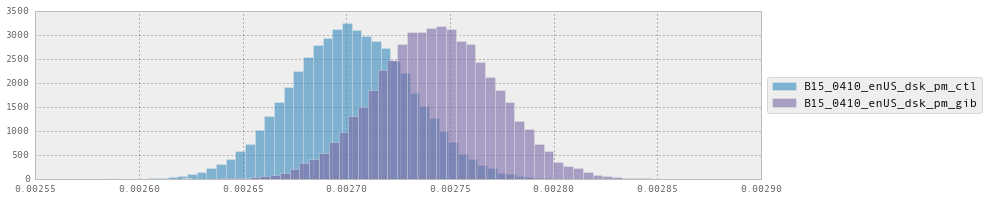

In [112]:
t_dsk_gw.rate_stats(a, b, rate = 'clicks/impressions')

,P(Winner),Winners Lift,CI
B15_0410_enUS_dsk_pm_gib,0.99978,"(0.00%, 0.00%)","(0.001887, 0.001983)"
B15_0410_enUS_dsk_pm_ctl,0.00022,"(2.79%, 10.38%)","(0.001770, 0.001863)"


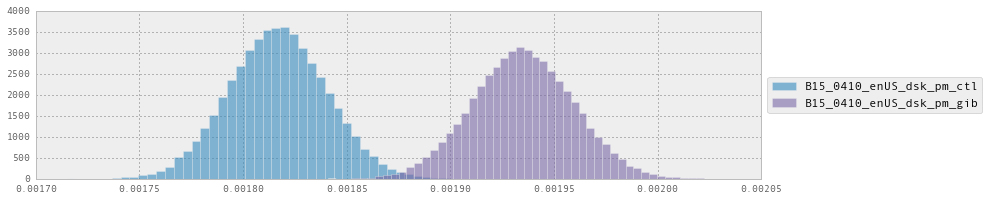

In [113]:
t_dsk_gw.rate_stats(a, b, rate = 'donations/impressions')

#Mobile

In [114]:
a = 'B15_0410_enUS_mob_pm_ctl'
b = 'B15_0410_enUS_mob_pm_gib'
t_mob = Test(a, b, start=start, stop = end)
#t_mob.get_payment_method_details()

donations  clicks  conversion_rate  \
B15_0410_enUS_mob_pm_ctl amazon        366     528        69.318182   
                         cc            229     653        35.068913   
                         paypal        660    1058        62.381853   
B15_0410_enUS_mob_pm_gib amazon        326     472        69.067797   
                         cc            275     731        37.619699   
                         paypal        660    1109        59.513075   

                                 percent clicked on  percent donated on  \
B15_0410_enUS_mob_pm_ctl amazon           23.581956           29.163347   
                         cc               29.164806           18.247012   
                         paypal           47.253238           52.589641   
B15_0410_enUS_mob_pm_gib amazon           20.415225           25.852498   
                         cc               31.617647           21.808089   
                         paypal           47.967128           52.339413   

                                 total_amount  ave_amount_ro  
B15_0410_enUS_mob_pm_ctl amazon       3092.00       8.448087  
                         cc           2700.50      10.224444  
                         paypal       5863.00       7.630137  
B15_0410_enUS_mob_pm_gib amazon       2678.00       8.214724  
                         cc           3499.00      10.776952  
                         paypal       5440.94       7.684360

In [121]:
# Doctor the Click and Donation Counts
clicks = 196
conversion_rate = 0.7
average_donation = 8.4
t_mob_gw = doctor_payment_data(t_mob, clicks, conversion_rate, average_donation, b, 'gw' )
t_mob_gw.get_payment_method_details()

donations  clicks  conversion_rate  \
B15_0410_enUS_mob_pm_ctl amazon        366     528        69.318182   
                         cc            229     653        35.068913   
                         paypal        660    1058        62.381853   
B15_0410_enUS_mob_pm_gib amazon        326     472        69.067797   
                         cc            275     731        37.619699   
                         gw            137     196        69.897959   
                         paypal        660    1109        59.513075   

                                 percent clicked on  percent donated on  \
B15_0410_enUS_mob_pm_ctl amazon           23.581956           29.163347   
                         cc               29.164806           18.247012   
                         paypal           47.253238           52.589641   
B15_0410_enUS_mob_pm_gib amazon           18.819777           23.319027   
                         cc               29.146730           19.670959   
                         gw                7.814992            9.799714   
                         paypal           44.218501           47.210300   

                                 total_amount  ave_amount_ro  
B15_0410_enUS_mob_pm_ctl amazon       3092.00       8.448087  
                         cc           2700.50      10.224444  
                         paypal       5863.00       7.630137  
B15_0410_enUS_mob_pm_gib amazon       2678.00       8.214724  
                         cc           3499.00      10.776952  
                         gw           1150.80            NaN  
                         paypal       5440.94       7.684360

,P(Winner),Winners Lift,CI
B15_0410_enUS_mob_pm_gib,0.99928,"(0.00%, 0.00%)","(0.003161, 0.003417)"
B15_0410_enUS_mob_pm_ctl,0.00072,"(3.70%, 16.24%)","(0.002873, 0.003119)"


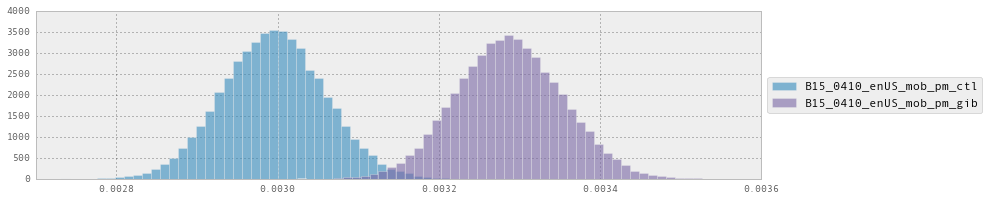

In [123]:
t_mob_gw.rate_stats(a, b, rate = 'clicks/impressions')

,P(Winner),Winners Lift,CI
B15_0410_enUS_mob_pm_gib,0.98874,"(0.00%, 0.00%)","(0.001739, 0.001930)"
B15_0410_enUS_mob_pm_ctl,0.01126,"(1.23%, 17.80%)","(0.001588, 0.001773)"


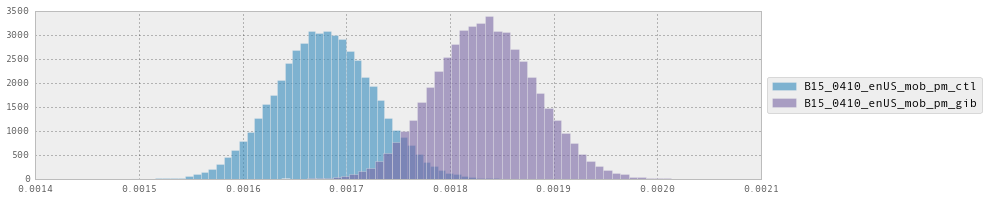

In [124]:
t_mob_gw.rate_stats(a, b, rate = 'donations/impressions')

#Ipad

In [128]:
 a = 'B15_0410_enUS_ipd_pm_ctl'
b = 'B15_0410_enUS_ipd_pm_gib'
t_ipd = Test(a, b, start=start, stop = end)
#t_ipd.get_payment_method_details()

In [127]:
# Doctor the Click and Donation Counts
clicks = 41
conversion_rate = 0.7
average_donation = 9.6
t_ipd_gw = doctor_payment_data(t_ipd, clicks, conversion_rate, average_donation, b, 'gw' )
t_ipd_gw.get_payment_method_details()

donations  clicks  conversion_rate  \
B15_0410_enUS_ipd_pm_ctl amazon        139     190        73.157895   
                         cc             78     209        37.320574   
                         paypal        238     352        67.613636   
B15_0410_enUS_ipd_pm_gib amazon        111     162        68.518519   
                         cc            100     238        42.016807   
                         gw             28      41        68.292683   
                         paypal        241     365        66.027397   

                                 percent clicked on  percent donated on  \
B15_0410_enUS_ipd_pm_ctl amazon           25.299601           30.549451   
                         cc               27.829561           17.142857   
                         paypal           46.870839           52.307692   
B15_0410_enUS_ipd_pm_gib amazon           20.099256           23.125000   
                         cc               29.528536           20.833333   
                         gw                5.086849            5.833333   
                         paypal           45.285360           50.208333   

                                 total_amount  ave_amount_ro  
B15_0410_enUS_ipd_pm_ctl amazon        1736.0       9.896296  
                         cc            1249.0      14.922078  
                         paypal        2676.0      10.110638  
B15_0410_enUS_ipd_pm_gib amazon        1420.0      12.000000  
                         cc            1539.0      14.535354  
                         gw             268.8            NaN  
                         paypal        3000.0      11.344538

,P(Winner),Winners Lift,CI
B15_0410_enUS_ipd_pm_gib,0.9284,"(0.00%, 0.00%)","(0.006490, 0.007451)"
B15_0410_enUS_ipd_pm_ctl,0.0716,"(-2.48%, 18.89%)","(0.006011, 0.006939)"


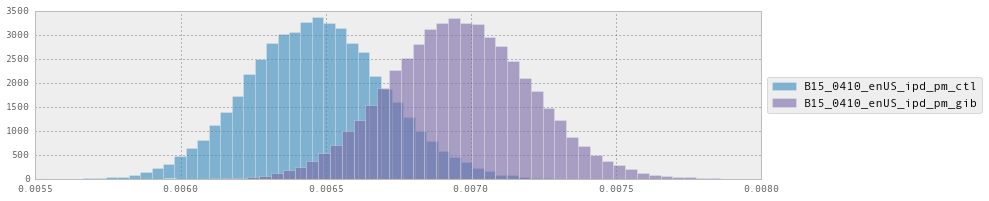

In [129]:
t_ipd_gw.rate_stats(a, b, rate = 'clicks/impressions')

,P(Winner),Winners Lift,CI
B15_0410_enUS_ipd_pm_gib,0.80934,"(0.00%, 0.00%)","(0.003786, 0.004534)"
B15_0410_enUS_ipd_pm_ctl,0.19066,"(-6.81%, 20.35%)","(0.003568, 0.004286)"


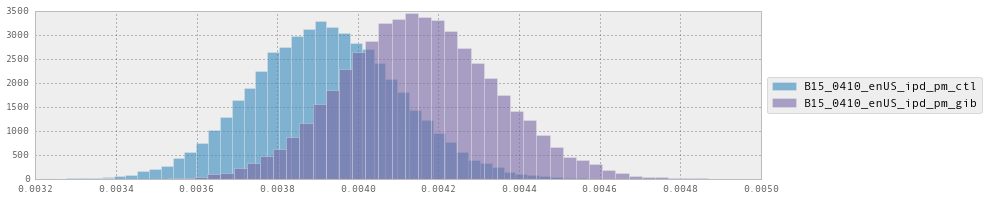

In [130]:
t_ipd_gw.rate_stats(a, b, rate = 'donations/impressions')